In [60]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [61]:
import numpy as np
import pandas as pd

In [62]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [63]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [64]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [65]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [66]:
# We can view all of the classes that automap found
Base.classes.keys()
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station


In [67]:
# trying inspector to see tables
inspector = inspect(engine)
inspector.get_table_names()

columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
    
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [68]:
# engine.execute('SELECT * FROM station LIMIT 10').fetchall()
# engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

# Create our session (link) from Python to the DB
session = Session(bind=engine)
# session.query(measurement.date).count()

for row in session.query(measurement.date, measurement.prcp).limit(5).all():
    print(row)
    
# measurement.__table__.columns.values()
# station.__table__.columns.values()

('2010-01-01', 0.08)
('2010-01-02', 0.0)
('2010-01-03', 0.0)
('2010-01-04', 0.0)
('2010-01-06', None)


# Exploratory Climate Analysis

TypeError: unhashable type: 'numpy.ndarray'

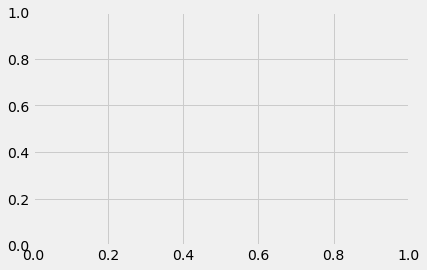

In [84]:
# Design a query to retrieve the last 12 months of precipitation data and plot the result

# find the last date returned ('2017-08-23')
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
last_date

# find the last 12 months of prcp data
year_date = session.query(measurement.date, measurement.prcp).filter(func.strftime("%Y", measurement.date) > '2016-08-23').all()
year_date

# Save the query results as a Pandas DataFrame and set the index to the date column
year_date_df = pd.read_sql(session.query(measurement.date, measurement.prcp).filter(func.strftime("%Y", measurement.date) > '2016-08-23').limit(100).statement,engine)

# Sort the dataframe by date (ordered in previous steps)
# year_date_df = year_date_df.sort_values("date")
bydate_df = year_date_df.groupby("date")

# Use Pandas Plotting with Matplotlib to plot the data
# fig, ax = plt.subplots()
# ypos = range(1, len(bydate_df.date)+1)
# ax.barh(ypos, bydate_df.date[::-1])
# ax.set_xlabel("Date")
# ax.set_ylabel("Precipitation")
# ax.set_yticks(ypos)
# ax.set_yticklabels(bydate_df.prcp[::-1])
# ax.set_title("Pecipitation by Date")
# fig.tight_layout()
# plt.show()

plt.scatter(bydate_df.date,bydate_df.prcp,c = bydate_df.prcp)
clb = plt.colorbar()
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.xticks(rotation=90)
clb.set_label("Precipitation")
plt.show()

In [74]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_date_df.describe()

,prcp
count,100.000000
mean,0.068500
std,0.303479
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,2.620000


In [ ]:
# Design a query to show how many stations are available in this dataset?


In [ ]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


In [ ]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
